# Gated Recurrent Units (GRU)

In the previous section we discussed how gradients are calculated in a recurrent neural network. In particular we found that long products of matrices can lead to vanishing or divergent gradients. Let’s briefly think about what such gradient anomalies mean in practice:

* We might encounter a situation where an early observation is highly significant for predicting all future observations. Consider the somewhat contrived case where the first observation contains a checksum and the goal is to discern whether the checksum is correct at the end of the sequence. In this case the influence of the first token is vital. We would like to have some mechanism for storing vital early information in a memory cell. Without such a mechanism we will have to assign a very large gradient to this observation, since it affects all subsequent observations.
* We might encounter situations where some symbols carry no pertinent observation. For instance, when parsing a webpage there might be auxiliary HTML code that is irrelevant for the purpose of assessing the sentiment conveyed on the page. We would like to have some mechanism for skipping such symbols in the latent state representation.
* We might encounter situations where there is a logical break between parts of a sequence. For instance there might be a transition between chapters in a book, a transition between a bear and a bull market for securities, etc.; In this case it would be nice to have a means of resetting our internal state representation.

A number of methods have been proposed to address this. One of the earliest is the Long Short Term Memory (LSTM)
of [Hochreiter and Schmidhuber, $1997^{175}$](http://papers.nips.cc/paper/1215-lstm-can-solve-hard-long-time-lag-problems.pdf) which we will discuss in Section 10.9. The Gated Recurrent Unit (GRU) of
[Cho et al., $2014^{176}$](https://arxiv.org/abs/1409.1259) is a slightly more streamlined variant that often offers comparable performance and is significantly faster to compute. See also [Chung et al., $2014^{177}$](https://arxiv.org/abs/1412.3555) for more details. Due to its simplicity we start with the GRU.

# Gating the Hidden State

The key distinction between regular RNNs and GRUs is that the latter support gating of the hidden state. This means
that we have dedicated mechanisms for when the hidden state should be updated and also when it should be reset. These
mechanisms are learned and they address the concerns listed above. For instance, if the first symbol is of great importance
we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary
observations. Lastly, we will learn to reset the latent state whenever needed. We discuss this in detail below.

## Reset Gates and Update Gates

The first thing we need to introduce are reset and update gates. We engineer them to be vectors with entries in (0, 1) such
that we can perform convex combinations, e.g. of a hidden state and an alternative. For instance, a reset variable would
allow us to control how much of the previous state we might still want to remember. Likewise, an update variable would
allow us to control how much of the new state is just a copy of the old state.

We begin by engineering gates to generate these variables. The figure below illustrates the inputs for both reset and update
gates in a GRU, given the current time step input $X_t$ and the hidden state of the previous time step $H_{t−1}$ . The output is
given by a fully connected layer with a sigmoid as its activation function.

Here, we assume there are h hidden units and, for a given time step t, the mini-batch input is $X_t$ ∈ $R^{n×d}$ (number of
examples: n, number of inputs: d) and the hidden state of the last time step is $H_{t−1}$ ∈ $R^{n×h}$ . Then, the reset gate
$R_t$ ∈ $R^{n×h}$ and update gate $Z_t$ ∈ $R^{n×h}$ are computed as follows:
$$R_t = σ(X_t W_{xr} + H_{t−1} W_{hr} + b_r )$$
$$Z_t = σ(X_t W_{xz} + H_{t−1} W_{hz} + b_z )$$

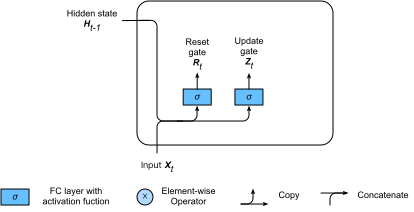

In [1]:
from IPython.display import SVG
SVG(filename= '../img/gru_1.svg')

Fig. 10.8.1: Reset and update gate in a GRU.

Here, $W_{xr}$ , $W_{xz}$ ∈ $R^{d×h}$ and $W_{hr}$ , $W_{hz}$ ∈ $R^{h×h}$ are weight parameters and $b_r$ , $b_z$ ∈ $R^{1×h}$ are biases. We use a
sigmoid function (see e.g. refer to Section 6.1 for a description) to transform values to the interval (0, 1).

## Reset Gate in Action

We begin by integrating the reset gate with a regular latent state updating mechanism. In a conventional deep RNN we
would have an update of the form

$$H_t = tanh(X_t W_{xh} + H_{t−1} W_{hh} + b_h ).$$

This is essentially identical to the discussion of the previous section, albeit with a nonlinearity in the form of tanh to
ensure that the values of the hidden state remain in the interval (−1, 1). If we want to be able to reduce the influence
of previous states we can multiply $H_{t−1}$ with $R_t$ elementwise. Whenever the entries in $R_t$ are close to 1 we recover a
conventional deep RNN. For all entries of $R_t$ that are close to 0 the hidden state is the result of an MLP with $X_t$ as input.
Any pre-existing hidden state is thus ‘reset’ to defaults. This leads to the following candidate for a new hidden state (it is
a candidate since we still need to incorporate the action of the update gate).

$$H̃_t = tanh(X_t W_{xh} + (R_t ⊙ H_{t−1} ) W_{hh} + b_h )$$

The figure below illustrates the computational flow after applying the reset gate. The symbol ⊙ indicates pointwise
multiplication between tensors.

## Update Gate in Action

Next we need to incorporate the effect of the update gate. This determines the extent to which the new state $H_t$ is just the
old state $H_{t−1}$ and by how much the new candidate state $H̃_t$ is used. The gating variable $Z_t$ can be used for this purpose,
simply by taking elementwise convex combinations between both candidates. This leads to the final update equation for
the GRU.

$$H_t = Z_t ⊙ H_{t−1} + (1 − Z_t ) ⊙ H̃_t .$$

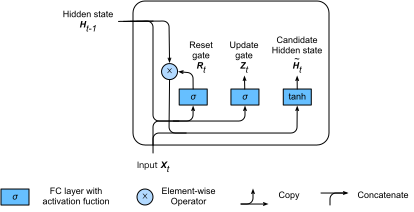

In [2]:
SVG(filename= '../img/gru_2.svg')

Fig. 10.8.2: Candidate hidden state computation in a GRU. The multiplication is carried out elementwise.

Whenever the update gate is close to 1 we simply retain the old state. In this case the information from $X_t$ is essentially
ignored, effectively skipping time step t in the dependency chain. Whenever it is close to 0 the new latent state $H_t$
approaches the candidate latent state $H̃_t$ . These designs can help cope with the vanishing gradient problem in RNNs and
better capture dependencies for time series with large time step distances. In summary GRUs have the following two
distinguishing features:

* Reset gates help capture short-term dependencies in time series.

* Update gates help capture long-term dependencies in time series.

## Implementation from Scratch

To gain a better understanding of the model let us implement a GRU from scratch.

### Reading the Data Set

We begin by reading The *Time Machine* corpus that we used in Section 10.5. The code for reading the data set is given
below:

In [3]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
from d2l import RNNModel 
from d2l import load_data_time_machine
from d2l import train_and_predict_rnn
from d2l import train_and_predict_rnn_nn
torch.set_default_tensor_type('torch.cuda.FloatTensor')

corpus_indices, vocab = load_data_time_machine()

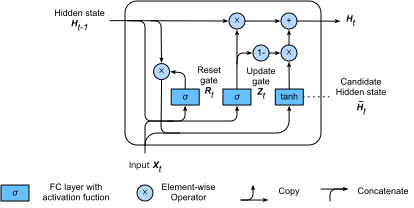

In [4]:
SVG(filename= '../img/gru_3.svg')

Fig. 10.8.3: Hidden state computation in a GRU. As before, the multiplication is carried out elementwise.

### Initialize Model Parameters

The next step is to initialize the model parameters. We draw the weights from a Gaussian with variance 0.01 and set the
bias to 0. The hyper-parameter *num_hiddens* defines the number of hidden units. We instantiate all terms relating to
update and reset gate and the candidate hidden state itself. Subsequently we attach gradients to all parameters.

In [5]:
num_inputs, num_hiddens, num_outputs = len(vocab), 256, len(vocab)
device = d2l.try_gpu()
print('Using', device)

Using cuda:0


In [6]:
def get_params():
    def _one(shape):
        return torch.randn(shape, device=device).normal_(std=0.01)
    
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = _three() # Update gate parameter
    W_xr, W_hr, b_r = _three() # Reset gate parameter
    W_xh, W_hh, b_h = _three() # Candidate hidden state parameter
    # Output layer parameters
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Create gradient
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Define the Model

Now we will define the hidden state initialization function *init_gru_state*. Just *like the init_rnn_state*
function defined in Section 10.5, this function returns a tuple composed of an tesor with a shape (batch size, number
of hidden units) and with all values set to 0.

In [7]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros(size=(batch_size, num_hiddens), device=device), )

Now we are ready to define the actual model. Its structure is the same as the basic RNN cell, just that the update equations
are more complex.

In [8]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        m = nn.Sigmoid()
        Z = m(torch.matmul(X.float(), W_xz) + torch.matmul(H.float(), W_hz) + b_z)
        R = m(torch.matmul(X.float(), W_xr) + torch.matmul(H.float(), W_hr) + b_r)
        h = nn.Tanh()
        H_tilda = h(torch.matmul(X.float(), W_xh) + torch.matmul(R * H.float(), W_hh) + b_h)
        H = Z * H.float() + (1 - Z) * H_tilda
        Y = torch.matmul(H.float(), W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

### Training and Prediction

Training and prediction work in exactly the same manner as before. That is, we need to define a number of epochs,
a number of steps for truncation, the minibatch size, a learning rate and how aggressively we should be clipping the
gradients. Lastly we create a string of 50 characters based on the prefixes *traveller* and *time traveller*.

In [9]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 100, 35, 32, 1, 1
prefixes = ['traveller', 'time traveller']
train_and_predict_rnn(gru, get_params, init_gru_state, num_hiddens,
                      corpus_indices, vocab, device, False, num_epochs,
                      num_steps, lr, clipping_theta, batch_size, prefixes)

epoch 50, perplexity 11.854904, time 14.74 sec
epoch 100, perplexity 9.288425, time 15.87 sec
 - travellere the the the the the the the the the the the the 
 - time travellere the the the the the the the the the the the the 


# Concise Implementation

In nn module, we can directly call the $GRU$ class in the $rnn$ module. This encapsulates all the configuration details that we
made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that
we spelled out in detail before.

In [10]:
gru_layer = nn.GRU(input_size=num_inputs, hidden_size=num_hiddens)
model = RNNModel(gru_layer, num_hiddens, len(vocab))
model.to(device)
train_and_predict_rnn_nn(model, num_hiddens, init_gru_state, corpus_indices, vocab,
                            device, num_epochs*5, num_steps, lr,
                            clipping_theta, batch_size, prefixes)

epoch 125, perplexity 6.661607, time 39.45 sec
epoch 250, perplexity 1.347627, time 38.69 sec
 - traveller smiled round at us. then, still smich, which are 
 - time traveller smiled round at us. then, still smich, which are 
epoch 375, perplexity 1.066841, time 39.30 sec
epoch 500, perplexity 1.040950, time 39.49 sec
 - traveller smiled. 'are you sure we can move freely in space
 - time traveller smiled. 'are you sure we can move freely in space


# Summary

* Gated recurrent neural networks are better at capturing dependencies for time series with large time step distances.
* Reset gates help capture short-term dependencies in time series.
* Update gates help capture long-term dependencies in time series.
* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can ignore sequences
as needed.

# Exercises

1) Compare runtimes, perplexity and the extracted strings for rnn.RNN and rnn.GRU implementations with each other.

2) Assume that we only want to use the input for time step t ′ to predict the output at time step t > t ′ . What are the best values for reset and update gates for each time step?

3) Adjust the hyper-parameters and observe and analyze the impact on running time, perplexity, and the written lyrics.

4) What happens if you implement only parts of a GRU? That is, implement a recurrent cell that only has a reset gate. Likewise, implement a recurrent cell only with an update gate.

# References

[1] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). On the properties of neural machine translation:
Encoder-decoder approaches. arXiv preprint arXiv:1409.1259.

[2] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on
sequence modeling. arXiv preprint arXiv:1412.3555.